In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
# print(os.listdir("././input"))
# print(os.listdir("././submit"))
from utils import save_data
SEED=1234
n_splits=10

In [3]:
train=pd.read_csv('./input/prep_train1102.csv')
test=pd.read_csv('./input/prep_test1102.csv')
y_train = train['賃料']

In [5]:
folder=KFold(n_splits=10, shuffle=True, random_state=45)

In [6]:
drop_col = ['id']

## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

In [7]:
X_train['地価']=X_train['賃料']/X_train['面積']

In [8]:
def feature_encoding(train, test, category_col, target_col, func_list):
    '''target_encodingを重要な列（面積など）でやる。TEと違って、test_dfに含まれる値も集計して作る'''
    data=pd.concat([train,test],axis=0).reset_index()
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = data.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

In [9]:
def target_encoding(train, test, category_col, target_col, func_list):
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = train.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test


category_col='km_type'

target_dict = {category_col: ['mean']}
target_col = '地価'
for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, target_col, func_list)

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']

In [10]:

X_train['地価'] = X_train['賃料'] / X_train['面積']
target_dict = {category_col: ['mean']}
target_col = '面積'
for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, target_col, func_list)

X_train['area_diff'] = X_train['面積'] - X_train[f'{category_col}_面積_mean']
X_train['area_ratio'] = X_train['面積'] / X_train[f'{category_col}_面積_mean']
X_test['area_diff'] = X_test['面積'] - X_test[f'{category_col}_面積_mean']
X_test['area_ratio'] = X_test['面積'] / X_test[f'{category_col}_面積_mean']

target_dict = {category_col: ['mean']}
target_col = '築年数'
for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, target_col, func_list)

X_train['age_diff'] = X_train['築年数'] - X_train[f'{category_col}_築年数_mean']
X_train['age_ratio'] = X_train['築年数'] / X_train[f'{category_col}_築年数_mean']
X_test['age_diff'] = X_test['築年数'] - X_test[f'{category_col}_築年数_mean']
X_test['age_ratio'] = X_test['築年数'] / X_test[f'{category_col}_築年数_mean']
X_train['area/ageratio'] = X_train['area_ratio'] / X_train['age_ratio']
X_test['area/ageratio'] = X_test['area_ratio'] / X_test['age_ratio']

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']
X_train['地価x面積/築年数ratio'] = X_train['地価x面積'] / X_train['age_ratio']
X_test['地価x面積/築年数ratio'] = X_test['地価x面積'] / X_test['age_ratio']


In [27]:
X_train['outlier']=0
X_train.loc[X_train.query('賃料>200000')['賃料'].index,'outlier']=1

In [33]:
y_train=X_train['outlier']

In [54]:
lgbm_params = {
    'num_iterations': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'reg_lambda': 68.19849585036235,
    'reg_alpha': 0.007585940082730346,
    'colsample_bytree': 0.6,
    'subsample': 0.5,
    'max_depth': 8,
    'min_child_weight': 8,
    'lambda': 1,
    'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }

lgbm_log_params=lgbm_params.copy()
lgbm_log_params['metric']='mae'
lgbm_log_params['learning_rate']=0.05

lgbm_x_params=lgbm_params.copy()
lgbm_x_params['metric']='binary'
lgbm_x_params['learning_rate']=0.05

In [55]:
features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階','km_type_地価_mean', '地価x面積', 'area_diff',
       'area_ratio', 'age_diff', 'age_ratio',
       'area/ageratio', '地価x面積/築年数ratio']
X_train = X_train[features]
X_test = X_test[features]

Training on fold 1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.0181458	valid_1's binary_logloss: 0.0333403
Training on fold 2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0290643	valid_1's binary_logloss: 0.0442326
Training on fold 3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0351203	valid_1's binary_logloss: 0.0472092
Training on fold 4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0322706	valid_1's binary_logloss: 0.0510848
Training on fold 5
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.0117069	valid_1's binary_logloss: 0.0322737
Training on fold 6
Trainin

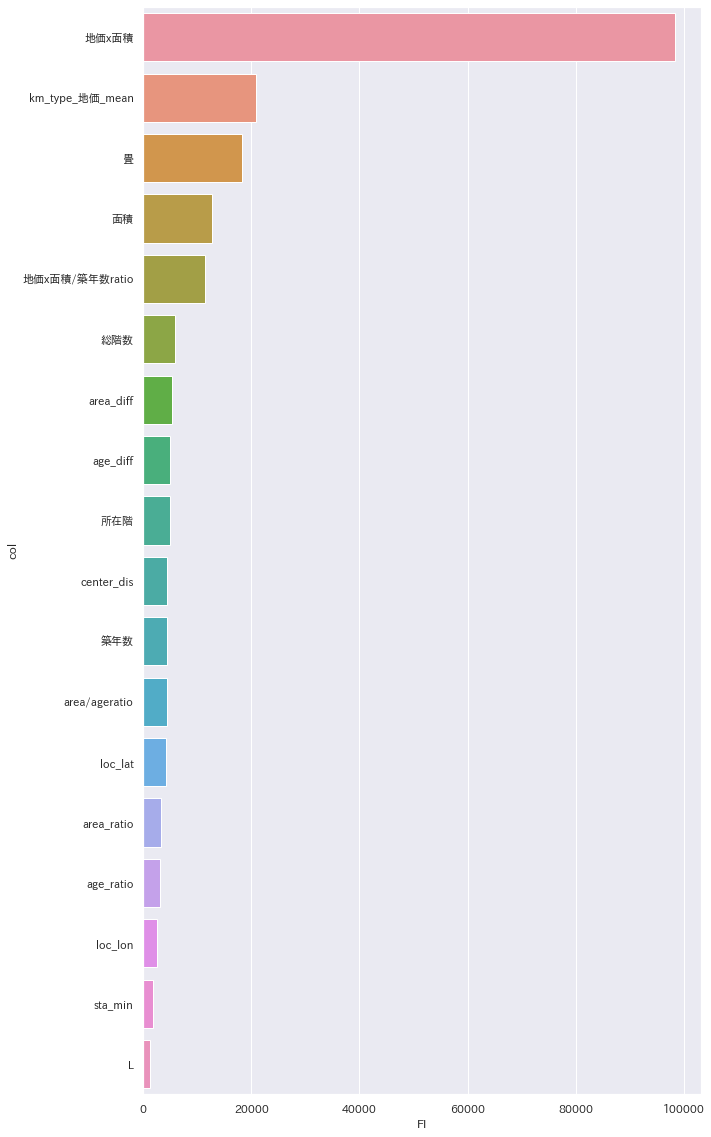

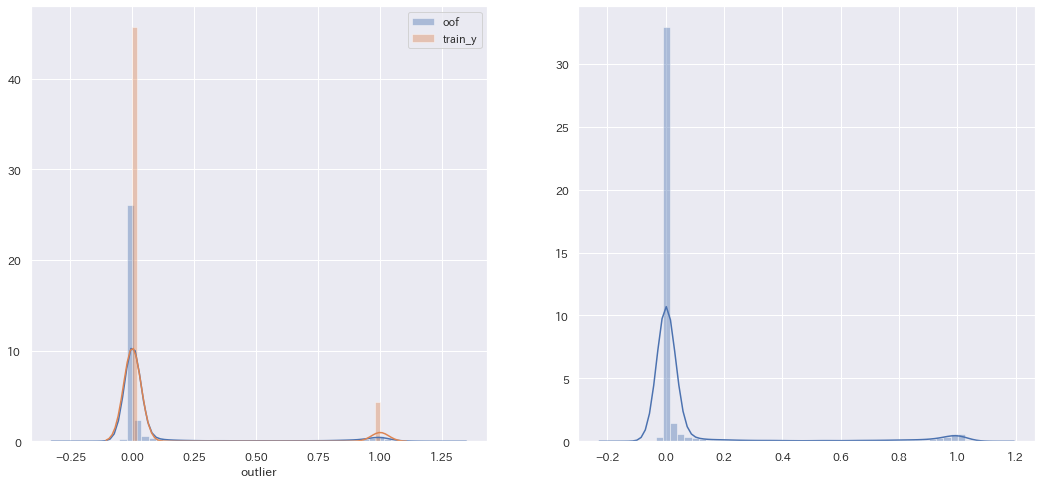

RMSE :  0.10651833875320671
R^2 :  0.8250558616132341


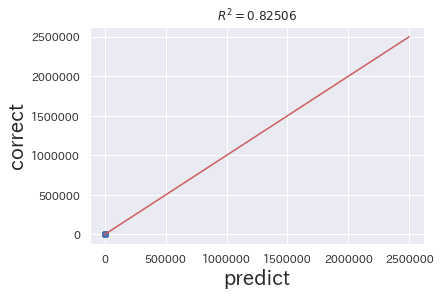

In [56]:
XLGBM = RegressionPredictor(X_train, y_train, X_test, Folder=folder, params=lgbm_x_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
xlgboof, xlgbpreds, xlgbFIs = XLGBM.fit()
XLGBM.plot_FI(50)
XLGBM.plot_pred_dist()
XLGBM.plot_scatter_oofvspred()

In [57]:
xlgbpreds

array([5.68048076e-03, 8.11193582e-03, 4.69285648e-04, ...,
       2.06526441e-02, 9.67985257e-01, 3.78351058e-04])

In [47]:
def save_data(train,oof,preds,rmse=20000,name='lgb',submit_dir='./submit',save_dir='./submit'):
    '''stacking用にtrain,testの予測値を同じ形で保存する
    from pathlib import Path　がいる
    predict.csvの情報を記載したcsvも作成する
    '''
    submit_dir=Path(submit_dir)
    save_dir=Path(save_dir)
    submit_path=submit_dir/'sample_submit.csv'
    train_id_path=submit_dir/'train_id.csv'
    pred_path=save_dir/f'submit_{rmse}_{name}.csv'
    oof_path=save_dir/f'oof_{rmse}_{name}.csv'
    train_log_path=save_dir/f'pred_log.csv'
    
    submit = pd.read_csv(submit_path,header=None).rename(columns={0:'id',1:'target'})
    train_oof=pd.read_csv(train_id_path,header=None).rename(columns={0:'id',1:'target'})
    submit['target'] = preds
    train_oof['target']=oof
    submit.to_csv(pred_path, index=None, header=None)
    train_oof.to_csv(oof_path, index=None, header=None)
    
    if train_log_path.is_file():
        train_log_df=pd.read_csv(train_log_path)
    else:
        train_log_df=pd.DataFrame(columns=['path','features','rmse','time'])
    s=pd.Series([pred_path,','.join(train.columns),rmse,str(datetime.date.today())],index=['path','features','rmse','time'],name=train_log_df.shape[0])
    train_log_df=train_log_df.append(s)
    train_log_df.to_csv(train_log_path,index=None)
    
    display(submit.head())
    display(train_oof.head())

In [58]:
save_data(X_train,xlgboof, xlgbpreds,rmse=XLGBM.rmse(),name='binoutlier',save_dir='./stacking')

,id,target
0,31471,0.005680
1,31472,0.008112
2,31473,0.000469
3,31474,0.000085
4,31475,-0.003395


,id,target
0,1,-0.000832
1,2,-0.002288
2,3,-0.001001
3,4,0.122840
4,5,0.002335


In [49]:
import pandas as pd
from pathlib import Path
import datetime